In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
courses_df = pd.read_csv('Data/courses.csv')

In [3]:
student_assessment_df = pd.read_csv('Data/studentAssessment.csv')

In [4]:
student_registration_df = pd.read_csv('Data/studentRegistration.csv')

In [5]:
assessments_df = pd.read_csv('Data/assessments.csv')

### Вывод из предварительного исследования: 

Курс -- уникальный предмет в границах одного семестра, на который в семестре зарегистрировалось больше 0 студентов, и у которого был проведен (или планировался) хотя бы один финальный экзамен.

собираем в датафрейм информацию о финальных экзаменах для каждого предмета в каждом семестре

фильтруем только экзамены, группируем по семестру и предмету, считаем количество финальных экзаменов для каждого

In [7]:
final_exams_df = assessments_df[assessments_df.assessment_type == 'Exam'] \
    .groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .rename(columns={'id_assessment':'final_exams'})

In [8]:
final_exams_df.head()

,code_module,code_presentation,final_exams
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1


собираем в датафрейм информацию о регистрации студентов на курсы

группируем по семестру и предмету, считаем количество регистраций

In [9]:
registered_students_df = student_registration_df.groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'id_student': 'count'})  \
    .rename(columns={'id_student':'total_students_registered'})

#### Cопоставляем информацию об экзаменах и регистрации, чтобы выделить полные курсы, увидеть их временные границы и распределение студентов.

In [10]:
main_course_info = final_exams_df.merge(registered_students_df, on=['code_module', 'code_presentation']) \
    .pivot(index='code_module', columns='code_presentation', values=['total_students_registered', 'final_exams']) \
    .fillna(0)

In [11]:
main_course_info

total_students_registered                          \
code_presentation                     2013B   2013J   2014B   2014J   
code_module                                                           
AAA                                     0.0   383.0     0.0   365.0   
BBB                                  1767.0  2237.0  1613.0  2292.0   
CCC                                     0.0     0.0  1936.0  2498.0   
DDD                                  1303.0  1938.0  1228.0  1803.0   
EEE                                     0.0  1052.0   694.0  1188.0   
FFF                                  1614.0  2283.0  1500.0  2365.0   
GGG                                     0.0   952.0   833.0   749.0   

                  final_exams                    
code_presentation       2013B 2013J 2014B 2014J  
code_module                                      
AAA                       0.0   1.0   0.0   1.0  
BBB                       1.0   1.0   1.0   1.0  
CCC                       0.0   0.0   2.0   2.0  
DDD                       1.0   1.0   1.0   1.0  
EEE                       0.0   1.0   1.0   1.0  
FFF                       1.0   1.0   1.0   1.0  
GGG                       0.0   1.0   1.0   1.0

### 1. Сколько студентов успешно сдали только один курс?

3774 выбравших один экзамен и сдавших его, 28 сдавших один из нескольких выбранных

#### Cобираем информацию об экзаменах, курсах и оценках в один датафрейм, склеиваем по id теста, так как он будет постоянным в обоих датафреймах

In [13]:
submitted_tests_data = assessments_df.merge(student_assessment_df, on='id_assessment')

заводим новую колонку "сдано" на основе баллов, чтобы было удобнее видеть завершаемость

In [14]:
submitted_tests_data['passed'] = np.where(submitted_tests_data.score >= 40, 1, 0)

делаем отдельный дф для удобства дальнейшей работы (и сокращения повторений в коде)

отбираем только экзамены, группируем по студентам, для каждого считаем кол-во всех экзаменов и кол-во успешных

In [15]:
final_exams_by_student = submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'id_assessment' : 'count', 'passed' : 'sum'})

считаем число студентов, сдавших только один курс (должен быть всего один экзамен, и он должен быть пройден)

In [16]:
only_one_exam_passed = final_exams_by_student.query('id_assessment == 1 & passed == 1').id_student.count()

only_one_exam_passed

3774

дополнительно считаем число студентов, сдавших один курс из нескольких пройденных
(должно быть более одного экзамена, из них должен быть пройден только один)

In [17]:
one_of_several_exams_passed = final_exams_by_student.query('id_assessment > 1 & passed == 1').id_student.count()

one_of_several_exams_passed

28

### ОТСТУПЛЕНИЕ

 в ходе просмотра полных данных о заданиях выяснилось, что у некоторых тестов вес равняется нулю.
 чтобы увидеть больше информации, находим такие тесты, группируем по семестру, курсу и тесту,
 и смотрим на кол-во попыток сдачи, количество перезачетов и среднюю оценку.
 заметно, что такое происходит систематически в рамках курсов FFF и GGG (и один раз в BBB),  
 нет корреляции с перезачетами, и что оценки и попытки сдачи логируются нормально.
можно сделать вывод, что в курсах задуманы дополнительные задания, не влияющие на итоговую оценку. 

In [18]:
submitted_tests_data.query('weight == 0') \
    .groupby(['code_module', 'code_presentation', 'assessment_type', 'id_assessment'], as_index=False) \
    .agg({
        'weight' : 'sum', 
        'id_student' : 'count', 
        'score' : lambda x: round(x.mean(), 2),
        'is_banked' : 'sum'
        }) \
     .head()

,code_module,code_presentation,assessment_type,id_assessment,weight,id_student,score,is_banked
0,BBB,2014J,TMA,15020,0.0,1776,58.87,0
1,FFF,2013B,CMA,34865,0.0,1091,83.13,1
2,FFF,2013B,CMA,34866,0.0,1016,87.73,0
3,FFF,2013B,CMA,34867,0.0,952,76.64,0
4,FFF,2013B,CMA,34868,0.0,922,78.37,0


### 2. Выявить самый сложный и самый простой экзамен: найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

#### подход 1: рассматриваем все тесты (включая экзамены, TMA и CMA)

id тестов с самой высокой завершаемостью (completion_rate = 1):

34879 (курс FFF поток 2013J); 34892, 34896 (курс FFF поток 2014B); 
34907 (курс FFF поток 2014J); 37429 (курс GGG поток 2014B) 

id тестов с самой низкой завершаемостью (completion_rate = 0.59) -- 15020 (курс BBB поток 2014J)

оставляем только нужную информацию и считаем кол-во попыток сдать экзамен

In [21]:
all_tests_comp = submitted_tests_data.groupby(
        ['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
    .agg({'score':'count'}) \
    .rename(columns={'score':'tests_taken'})

считаем кол-во успешно сданных экзаменов

In [22]:
all_tests_comp['tests_passed'] = submitted_tests_data.query('score >= 40') \
                                    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
                                    .agg({'score':'count'}) \
                                    .score

считаем коэффициент завершаемости

In [23]:
all_tests_comp['completion_rate'] = all_tests_comp.tests_passed / all_tests_comp.tests_taken

In [24]:
t_max_completion = all_tests_comp[all_tests_comp.completion_rate == all_tests_comp.completion_rate.max()]
t_max_completion

,code_module,code_presentation,id_assessment,tests_taken,tests_passed,completion_rate
131,FFF,2013J,34879,1352,1352,1.0
143,FFF,2014B,34892,857,857,1.0
147,FFF,2014B,34896,747,747,1.0
157,FFF,2014J,34907,1234,1234,1.0
174,GGG,2014B,37429,559,559,1.0


In [25]:
t_min_completion = all_tests_comp[all_tests_comp.completion_rate == all_tests_comp.completion_rate.min()]
t_min_completion

,code_module,code_presentation,id_assessment,tests_taken,tests_passed,completion_rate
43,BBB,2014J,15020,1772,1040,0.586907


#### подход 2: рассматриваем только финальные экзамены

порядок действий идентичен первому подходу, изменяется только тип рассматриваемого теста

Стоит заметить, что для всех курсов, кроме CCC и DDD, нет финальных экзаменов, присланных на оценку, 
 хотя в данных о планируемых экзаменах они присутствуют. Предполагаю, что они либо просто не были залогированы,
 либо были отменены (что менее вероятно). В любом случае невозможно узнать их завершаемость.

 - id экзамена с самой высокой завершаемостью (completion_rate == 0.93) -- 25361 (курс DDD поток 2014B)
 - id экзамена с самой низкой завершаемостью (completion_rate == 0.84) -- 25340 (курс DDD поток 2013B)

In [27]:
final_exams_comp = submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
    .agg({'score':'count'}) \
    .rename(columns={'score':'exams_taken'})

In [28]:
final_exams_comp['exams_passed'] = submitted_tests_data.query('assessment_type == "Exam" & score >= 40') \
                                    .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index=False) \
                                    .agg({'score':'count'}) \
                                    .score

In [29]:
final_exams_comp = final_exams_comp.assign(
    completion_rate = final_exams_comp.exams_passed / final_exams_comp.exams_taken
    )

In [30]:
ex_max_completion = final_exams_comp[final_exams_comp.completion_rate == final_exams_comp.completion_rate.max()]
ex_max_completion

,code_module,code_presentation,id_assessment,exams_taken,exams_passed,completion_rate
4,DDD,2014B,25361,524,485,0.925573


In [31]:
ex_min_completion = final_exams_comp[final_exams_comp.completion_rate == final_exams_comp.completion_rate.min()]
ex_min_completion

,code_module,code_presentation,id_assessment,exams_taken,exams_passed,completion_rate
2,DDD,2013B,25340,602,504,0.837209


### 3. По каждому предмету определить средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

#### текущие оценки:
- ААА: TMA -- 115, в среднем сдано позже дедлайна
- BBB: CMA -- 127, в среднем сдано позже дедлайна; TMA -- 105, в среднем сдано до дедлайна
- CCC: CMA -- 112, в среднем сдано позже дедлайна; TMA -- 123, в среднем сдано до дедлайна
- DDD: CMA -- 116, в среднем сдано позже дедлайна; TMA -- 103, в среднем сдано до дедлайна
- FFF: CMA -- 160, в среднем сдано до дедлайна; TMA -- 94, в среднем сдано до дедлайна
- GGG: CMA -- 180, в среднем сдано до дедлайна; TMA -- 116, в среднем сдано до дедлайна

#### финальные экзамены:
- CCC -- 238
- DDD -- 237

для начала узнаем разницу между окончательной датой сдачи теста и фактической датой сдачи.
для перезачетов по умолчанию ставим разницу 0, в вычислениях среднего их учитывать не будем

In [33]:
submitted_tests_data.loc[submitted_tests_data.is_banked == 0, 'date_delta'] = \
    submitted_tests_data.date_submitted - submitted_tests_data.date
submitted_tests_data.loc[submitted_tests_data.is_banked == 1, 'date_delta'] = 0

важно уточнить, что работы, отправленные после дедлайна, зачитываются так же,
как отправленные в срок (без минуса к оценке). доказательство:

In [34]:
submitted_tests_data.query('assessment_type != "Exam" & is_banked == 0 & date_delta > 0') \
    .score.max()

100.0

так как для финальных экзаменов дата сдачи NaN, их стоит рассмотреть отдельно, сначала рассмотрим текущие тесты

1. отбираем успешно сданные текущие тесты без перезачетов
2. делаем разбивку по предмету, типу теста и отдельным тестам, для каждого считаем среднюю дату прохождения и отклонение от окончательной даты сдачи
3. делаем более широкую разбивку по предмету и типу теста, считаем те же показатели

In [35]:
submit_dates_data = submitted_tests_data.query('score >= 40 & assessment_type != "Exam" & is_banked == 0') \
    .groupby(['code_module', 'assessment_type', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'mean', 'date_delta': 'mean'}) \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg({'date_submitted': 'mean', 'date_delta': 'mean'}) \
    .rename(columns={'date_submitted': 'date_submitted_mean', 'date_delta':'date_delta_mean'})

1. отбираем успешно сданные текущие экзамены без перезачетов
2. делаем разбивку по предмету и отдельным тестам, для каждого считаем среднюю дату прохождения
3. делаем более широкую разбивку по предмету, считаем те же показатели

In [36]:
exam_submit_dates_data = submitted_tests_data.query('score >= 40 & assessment_type == "Exam" & is_banked == 0') \
    .groupby(['code_module', 'id_assessment'], as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .groupby('code_module', as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns={'date_submitted': 'date_submitted_mean'})

### 4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

- самые популярные предметы -- BBB (7909 регистраций), FFF (7762 регистрации), DDD (6272 регистрации)

- предметы с самым большим оттоком:
    - в абсолютных значениях -- FFF (1687 отмен), DDD (1639 отмен), CCC (1448 отмен)
    - в доле от общего числа -- CCC (33% отмен), DDD (26% отмен), FFF (22% отмен)

 4.1 для каждого предмета считаем количество зарегистрировавшихся студентов (один студент = одна регистрация) и выводим топ-3 

регистрацию одних и тех же студентов на один предмет в разных семестрах считаем как отдельные регистрации, так как считаем курс за отдельно взятый предмет в рамках отдельно взятого семестра

отмененные регистрации тоже засчитываем, так как здесь важна именно изначальная популярность курса

1. создаем датафрейм с информацией обо всех регистрациях для каждого предмета

In [39]:
registration_by_module = student_registration_df.groupby('code_module', as_index = False) \
    .agg({'id_student': 'count'}) \
    .rename(columns = {'id_student': 'registered_students'})

 2. выводим топ-3 предмета 

In [40]:
registration_by_module.sort_values('registered_students', ascending = False).head(3)

,code_module,registered_students
1,BBB,7909
5,FFF,7762
3,DDD,6272


4.2 считаем количество отмененных регистраций `(date_unregistration > 0)`, это будет объем оттока

In [41]:
registration_by_module['unregistered_students'] = student_registration_df.query('date_unregistration > 0') \
    .groupby('code_module', as_index = False) \
    .agg({'id_student': 'count'}) \
    .id_student

для более полной картины можно узнать долю оттока, для этого делим объем оттока на общее число регистраций 



In [42]:
registration_by_module['unreg_share'] = \
    registration_by_module.unregistered_students / registration_by_module.registered_students * 100

сначала выводим топ-3 по оттоку в абсолютных значениях



In [43]:
registration_by_module.sort_values('unregistered_students', ascending = False).head(3)

,code_module,registered_students,unregistered_students,unreg_share
5,FFF,7762,1687,21.734089
3,DDD,6272,1639,26.132015
2,CCC,4434,1448,32.656743


и в относительных



In [44]:
registration_by_module.sort_values('unreg_share', ascending = False).head(3)

,code_module,registered_students,unregistered_students,unreg_share
2,CCC,4434,1448,32.656743
3,DDD,6272,1639,26.132015
5,FFF,7762,1687,21.734089


### 5. С начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

- самая низкая завершаемость -- 2013B (0.84)
- самые долгие сроки сдачи -- 2013J (261 день с начала семестра)
- самая поздняя сдача -- 2014J (244 дня с начала семестра)
- самая поздняя сдача относительно срока -- 2014B (6 дней до срока сдачи)

для начала смотрим, были ли студенты, сдававшие экзамены несколько раз (нет)



In [46]:
submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby(['code_presentation', 'id_assessment' ,'id_student'], as_index = False) \
    .agg({'score' : 'count'}) \
    .query('score > 1') 

,code_presentation,id_assessment,id_student,score


(данные и есть с начала 2013 по конец 2014, поэтому фильтровать не нужно)

здесь все так же, как во втором и третьем вопросе, только для семестров: отбираем только финальные экзамены с группировкой по семестру, считаем кол-во всех попыток и кол-во успешных,  из этого выводим завершаемость и считаем средние сроки сдачи и среднюю фактическую дату сдачи относительно срока сдачи

In [48]:
exams_by_semester = submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby('code_presentation', as_index = False) \
    .agg({
        'id_student' : 'count', 
        'date_submitted' : lambda x: round(x.mean(), 0), 
        'date_delta' : lambda x: round(x.mean(), 0), 
        'date' : 'mean'
        }) \
    .rename(columns = 
            {
            'id_student':'exams_taken', 
            'date_submitted' : 'mean_submit_date', 
            'date_delta' : 'mean_date_delta', 
            'date' : 'mean_date'
            })

In [49]:
exams_by_semester['exams_passed'] = submitted_tests_data.query('assessment_type == "Exam" & score >= 40') \
    .groupby('code_presentation', as_index = False) \
    .agg({'id_student': 'count'}) \
    .id_student

In [50]:
exams_by_semester['completion_rate'] = (exams_by_semester.exams_passed / exams_by_semester.exams_taken).round(2)

видно, что для семестра 2014J нет данных о сроках сдачи, нужно дописследование (ниже)



In [51]:
exams_by_semester

,code_presentation,exams_taken,mean_submit_date,mean_date_delta,mean_date,exams_passed,completion_rate
0,2013B,602,230,-10.0,240.0,504,0.84
1,2013J,968,240,-21.0,261.0,878,0.91
2,2014B,1271,233,-6.0,241.0,1149,0.90
3,2014J,2118,244,NaN,NaN,1861,0.88


здесь можно увидеть, что для некоторых курсов нет данных о сроках сдачи экзаменов

предполагаю, что для этих  экзаменов не было фиксированной окончательной даты сдачи. в связи с этим имеет смысл ориентироваться также на фактическую дату сдачи для всех экзаменов



In [52]:
submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby(['code_presentation', 'code_module'], as_index = False) \
    .agg({'date':'mean', 'date_submitted': lambda x: round(x.mean(), 0)})

,code_presentation,code_module,date,date_submitted
0,2013B,DDD,240.0,230
1,2013J,DDD,261.0,240
2,2014B,CCC,NaN,232
3,2014B,DDD,241.0,235
4,2014J,CCC,NaN,244
5,2014J,DDD,NaN,243


In [53]:
lowest_sem_comp_rate = exams_by_semester[
    exams_by_semester.completion_rate == exams_by_semester.completion_rate.min()
    ]
lowest_sem_comp_rate

,code_presentation,exams_taken,mean_submit_date,mean_date_delta,mean_date,exams_passed,completion_rate
0,2013B,602,230,-10.0,240.0,504,0.84


In [54]:
latest_sem_exam_date = exams_by_semester[
    exams_by_semester.mean_date == exams_by_semester.mean_date.max()
    ]
latest_sem_exam_date

,code_presentation,exams_taken,mean_submit_date,mean_date_delta,mean_date,exams_passed,completion_rate
1,2013J,968,240,-21.0,261.0,878,0.91


In [55]:
latest_sem_submit_date = exams_by_semester[
    exams_by_semester.mean_submit_date == exams_by_semester.mean_submit_date.max()
    ]
latest_sem_submit_date

,code_presentation,exams_taken,mean_submit_date,mean_date_delta,mean_date,exams_passed,completion_rate
3,2014J,2118,244,NaN,NaN,1861,0.88


In [56]:
latest_sem_submission = exams_by_semester[
    exams_by_semester.mean_date_delta == exams_by_semester.mean_date_delta.max()
    ]
latest_sem_submission

,code_presentation,exams_taken,mean_submit_date,mean_date_delta,mean_date,exams_passed,completion_rate
2,2014B,1271,233,-6.0,241.0,1149,0.9


### 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию.
    - R - среднее время сдачи одного экзамена, 
    - F - завершаемость курсов, 
    - M - среднее количество баллов, получаемое за экзамен. 
### Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

важное замечание: данные здесь будут недостаточно полными для понимания общей картины, из-за все того же отсутствия логов финальных экзаменов для большинства курсов. но посмотрев на долю студентов на курсах с логами финальных экзаменов (CCC и DDD), можно сказать, что наших данных (30% от всех регистраций, и это не учитывая регистрации студентов), вполне достаточно для примерного понимания всей аудитории



In [58]:
registration_by_module.query('code_module == "CCC" | code_module == "DDD"').registered_students.sum() / \
registration_by_module.registered_students.sum()

0.32847543951155156

из решения задания 5 мы знаем, что студенты не сдавали одни и те же экзамены по несколько раз.
также можно убедиться, что в наших данных нет перезачетов, засчитанных вместе со сдачей экзаменов, так как такое может мешать рассчетам средней даты сдачи

берем данные по каждому студенту в интересующих нас данных и смотрим на перезачеты



In [59]:
submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'is_banked':'sum'}) \
    .query('is_banked > 0')

,id_student,is_banked


собираем всю нужную для создания кластеров информацию -- группируем по студентам, для каждого считаем средние дату сдачи  тестов, оценку, кол-во уникальных экзаменов и количество пройденных



In [60]:
rfm_df = submitted_tests_data.query('assessment_type == "Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted':'mean', 
          'score' : 'mean',
          'id_assessment' : lambda x: x.nunique(),
          'passed' : 'sum'
         }) \
    .rename(columns={'id_assessment' : 'exams_taken', 
                     'date_submitted' : 'mean_date',
                     'score' : 'mean_score'
                    })

выводим коэффициент завершаемости -- кол-во сданных эказменов делим на кол-во всех попыток

In [61]:
rfm_df['comp_rate'] = rfm_df.passed / rfm_df.exams_taken

с помощью метода describe смотрим на статы для всех показателей



In [62]:
rfm_df.describe()

,id_student,mean_date,mean_score,exams_taken,passed,comp_rate
count,4.633000e+03,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000
mean,7.256904e+05,238.462227,65.117958,1.070365,0.947982,0.881286
std,5.753498e+05,5.653378,20.470561,0.255788,0.420354,0.321142
min,2.369800e+04,229.000000,0.000000,1.000000,0.000000,0.000000
25%,5.011580e+05,234.000000,50.000000,1.000000,1.000000,1.000000
50%,5.884820e+05,241.000000,66.000000,1.000000,1.000000,1.000000
75%,6.463510e+05,243.000000,82.000000,1.000000,1.000000,1.000000
max,2.698251e+06,285.000000,100.000000,2.000000,2.000000,1.000000


считаю правильным использовать квантили для кластеризации, так как это более адаптивный и удобный метод в работе со сложно сегментируемыми данными. однако для кластеризации по завершаемости буду использовать обычные ранги - разбивка по квантилям не имеет смысла (у подавляющей части студентов коэффициент = 1, и очень маленький разброс значений)

ранги для завершаемости строим, основываясь на всех видимых значениях метрики:
1. 0 - 0.49 
2. 0.5 - 0.99 
3. 1



In [64]:
rfm_df.comp_rate.value_counts()

1.0    4069
0.0     536
0.5      28
Name: comp_rate, dtype: int64

выводим квантили для всех остальных метрик. для них будем классически отбирать по 20%, разброс и диапазон значений достаточно большой, так что можно это не адаптировать

таким образом у нас будут две метрики с пятью рангами и одна с тремя


In [65]:
quantiles = rfm_df[['mean_score', 'mean_date']].quantile([.2, .4, .6, .8]).to_dict()

#### здесь создаем три функции:
    - одна для "отрицательно зависимой" метрики (средняя дата сдачи): чем больше значение, тем хуже
    - вторая для "положительно зависимой" (средняя оценка): чем больше, тем лучше
    - третья для метрики с тремя рангами, тоже "положительно зависимой"
    
для простоты восприятия переименуем наши метрики в d(date), c(completion), s(score)



In [66]:
def d_score(x):
    if x <= quantiles['mean_date'][.2]:
        return 5
    elif x <= quantiles['mean_date'][.4]:
        return 4
    elif x <= quantiles['mean_date'][.6]:
        return 3
    elif x <= quantiles['mean_date'][.8]:
        return 2
    else:
        return 1

def s_score(x):
    if x <= quantiles['mean_score'][.2]:
        return 1
    elif x <= quantiles['mean_score'][.4]:
        return 2
    elif x <= quantiles['mean_score'][.6]:
        return 3
    elif x <= quantiles['mean_score'][.8]:
        return 4
    else:
        return 5 
    
def c_score(x):
    if x == 0:
        return 1
    elif x <= 0.5:
        return 2
    else:
        return 3

просто применяем функции к исходным колонкам через лямбду, чтобы получить колонки с рангами



In [67]:
rfm_df['d'] = rfm_df.mean_date.apply(lambda x: d_score(x))
rfm_df['s'] = rfm_df.mean_score.apply(lambda x: s_score(x))
rfm_df['c'] = rfm_df.comp_rate.apply(lambda x: c_score(x))

сшиваем все значения рангов в одну колонку для дальнейшей работы



In [68]:
rfm_df['dsc'] = rfm_df.d.map(str) + rfm_df.s.map(str) + rfm_df.c.map(str)

In [69]:
rfm_df.head()

,id_student,mean_date,mean_score,exams_taken,passed,comp_rate,d,s,c,dsc
0,23698,243.0,80.0,1,1,1.0,2,4,3,243
1,24213,236.0,58.0,1,1,1.0,4,2,3,423
2,27116,243.0,96.0,1,1,1.0,2,5,3,253
3,28046,237.0,40.0,1,1,1.0,4,1,3,413
4,28787,243.0,44.0,1,1,1.0,2,1,3,213


#### три следующих графика -- распределение всех значений кластеров

на них видно, что для даты и оценки значения распределены в целом равномерно, хотя для даты доминирует кластер 4, а для оценок кластер 2, распределение кластеров по завершаемости неравномерное, подавляющее большинство студентов сдает все экзамены, есть небольшая доля не сдавших экзамены совсем, и, что интересно, совсем мизерная часть сдавших только часть

можно сделать вывод, что в исследуемой группе есть склонность завершать курсы быстро, но не всегда качественно

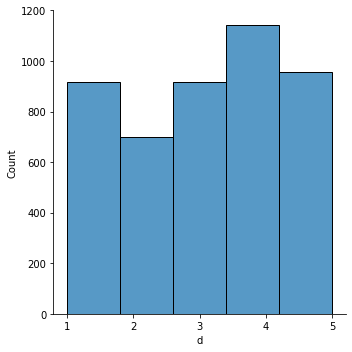

In [70]:
sns.displot(data=rfm_df, x=rfm_df.d, bins=5)
sns.set(rc={'figure.figsize': (7, 5), 'grid.linestyle': ':'}, style='whitegrid')

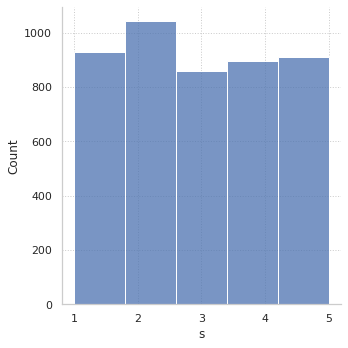

In [71]:
sns.displot(data=rfm_df, x=rfm_df.s, bins=5)
sns.set(rc={'figure.figsize': (8, 5), 'grid.linestyle': ':'}, style='whitegrid')

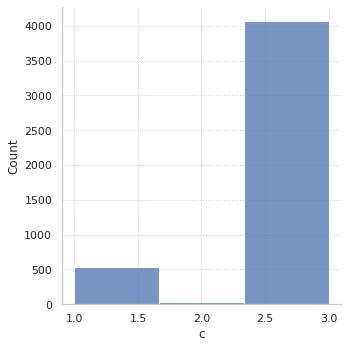

In [72]:
sns.displot(data=rfm_df, x=rfm_df.c, bins=3)
sns.set(rc={'figure.figsize': (8, 5), 'grid.linestyle': ':'}, style='whitegrid')

чтобы понять, с чего начать строить сегменты, посмотрим, как ранги разных метрик взаимосвязаны:
сколько разных рангов одних переменных существуют внутри рангов других.
дополнительно узнаем долю от каждой метрики в кластере, чтобы понимать возможность зависимости 
удобнее всего это начать делать с метрики завершаемости

 смотрим на варианты значений S в зависимости от значений С.
 ожидаемо, люди, которые получают оценки лучше, имеют более высокий коэф. завершаемости, нулевой только у 1 ранга

In [74]:
print(rfm_df[rfm_df.c == 1].s.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.c == 2].s.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.c == 3].s.value_counts(normalize=True).round(3))

1    1.0
Name: s, dtype: float64
2    0.536
1    0.464
Name: s, dtype: float64
2    0.253
5    0.224
4    0.220
3    0.211
1    0.093
Name: s, dtype: float64


смотрим на варианты значений D в зависимости от значений С

здесь разброса значительно больше, тоже вполне ожидаемо (помним, что работы, сданные в любую дату, зачитываются)
также не видно никакой взаимосвязи между высотой рангов обоих метрик

In [75]:
print(rfm_df[rfm_df.c == 1].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.c == 2].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.c == 3].d.value_counts(normalize=True).round(3))

5    0.248
1    0.218
4    0.211
3    0.174
2    0.149
Name: d, dtype: float64
3    0.464
4    0.286
2    0.143
5    0.107
Name: d, dtype: float64
4    0.251
5    0.202
3    0.199
1    0.196
2    0.151
Name: d, dtype: float64


уже ясно, что за основу будем брать метрики D и S, здесь посмотрим на них подробнее

In [76]:
print(rfm_df[rfm_df.s == 1].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.s == 2].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.s == 3].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.s == 4].d.value_counts(normalize=True).round(3))
print(rfm_df[rfm_df.s == 5].d.value_counts(normalize=True).round(3))

5    0.261
1    0.219
4    0.209
3    0.176
2    0.135
Name: d, dtype: float64
4    0.233
5    0.226
3    0.208
2    0.177
1    0.155
Name: d, dtype: float64
4    0.279
3    0.210
5    0.187
1    0.176
2    0.148
Name: d, dtype: float64
4    0.279
3    0.235
5    0.187
2    0.150
1    0.150
Name: d, dtype: float64
1    0.292
4    0.239
5    0.167
3    0.161
2    0.141
Name: d, dtype: float64


#### принцип разбивки на сегменты:

- champions -- отличники, высокие оценки и быстрые сроки сдачи
- promising -- средние сроки сдачи, но высокие оценки. есть, что подтянуть, но результат отличный
- average -- "середнячки", более-менее хорошие сроки сдачи, но не лучшие оценки
- going too fast -- быстрые сроки сдачи, полученные за счет низкого качества работы
- great but late -- наоборот, высокие оценки и долгие сроки сдачи. 
    - альтернативное название -- disorganized geniuses, для способных студентов с проблемой прокрастинации
- need attention -- ребята, которых надо спасать, подают надежды, но начинают проваливаться
- about to sleep -- ребята, которых надо срочно спасать, средние показатели по скорости, но совсем плохие оценки
- hibernating -- "двоечники", тут в принципе все понятно

In [91]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'3[1-2]': 'about to sleep',
    r'[1-2][3-4]': 'need attention',
    r'[1-2]5': 'great but late',
    r'[4-5][1-2]': 'going too fast',
    r'[3-5]3': 'average',
    r'[3-4][4-5]': 'promising',
    r'5[4-5]': 'champions'
}

rfm_df['segment'] = rfm_df['d'].map(str) + rfm_df['s'].map(str)
rfm_df['segment'] = rfm_df['segment'].replace(segt_map, regex=True)
rfm_df.head()

,id_student,mean_date,mean_score,exams_taken,passed,comp_rate,d,s,c,dsc,segment
0,23698,243.0,80.0,1,1,1.0,2,4,3,243,need attention
1,24213,236.0,58.0,1,1,1.0,4,2,3,423,going too fast
2,27116,243.0,96.0,1,1,1.0,2,5,3,253,great but late
3,28046,237.0,40.0,1,1,1.0,4,1,3,413,going too fast
4,28787,243.0,44.0,1,1,1.0,2,1,3,213,hibernating


смотрим на долю каждого сегмента в процентах
 
 выводы не очень радостные -- студентов с худшими показателями в два раза больше, чем с лучшими
 ожидаемо довольно большая часть студентов со средними и средне-хорошими оценками и сроками сдачи

In [85]:
rfm_df.segment.value_counts(normalize=True).round(3).mul(100)

going too fast    19.7
promising         17.8
hibernating       14.6
average           12.5
need attention    11.8
great but late     8.5
about to sleep     8.2
champions          6.9
Name: segment, dtype: float64

делаем дф для красивого сортированного графика про сегменты



In [79]:
rfm_df_sorted = rfm_df.groupby('segment', as_index=False) \
    .agg({'id_student':'count'}) \
    .sort_values('id_student', ascending=False) 
rfm_df_sorted['percent'] = (rfm_df_sorted.id_student / rfm_df_sorted.id_student.sum() * 100).round(2)

красивый график для наглядности долей всех сегментов



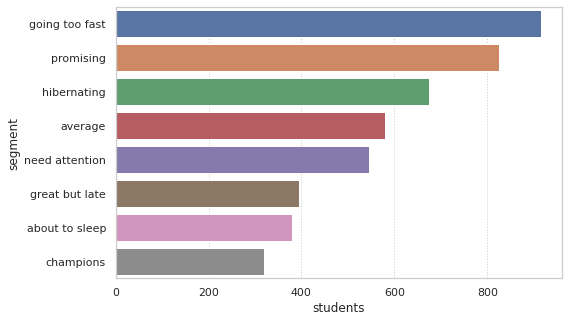

In [80]:
sns.barplot(data=rfm_df_sorted, y=rfm_df_sorted.segment, x=rfm_df_sorted.id_student, orient='h')
plt.xlabel('students')
sns.set(rc={'figure.figsize': (9, 6), 'grid.linestyle': ':'}, style='whitegrid')